# Exploration in Linear Bandits

The objective of this part is to implement and compare the following strategies for linear bandits:

[Optimism in the Face of Uncertainty (LinUCB/OFUL)](https://papers.nips.cc/paper/4417-improved-algorithms-for-linear-stochastic-bandits.pdf)

[Thompson Sampling](https://projecteuclid.org/euclid.ejs/1513306870)

## Linear bandit
We consider the standard linear bandit setting. At each time $t$, the agent selects an arm $a_t \in A$ and observes a reward
$$
r_{a}^t = \langle \theta^\star, \phi_a^t \rangle + \eta_a^t := \mu_a^t + \eta_a^t
$$
where $\theta^{\star} \in \mathbb{R}^{d}$ is a parameter vector, $\phi_{a}^t \in \mathbb{R}^{d} $ are the features of arm $a$ at time $t$, and $\eta_{a}^{t}$ is a zero-mean  $\sigma^2$-subgaussian noise. 

When the features correspond to the canonical basis, this formulation reduces to multi-armed bandit (MAB) with $d$ arms. In the more general case, the features may depend on a context $x_t$, so that $\phi_a^t = \phi(x_t, a)$ denotes the feature vector of a context-action pair $(x_t, a)$ and the resulting setting is the so-called linear contextual bandit.

We rely on the following standard assumption on the features and the unknown parameter $\theta^\star$.

**Assumption.** There exist $B,D \geq 0$, such that $\|\theta^\star\|_2 \leq B$, $\|\phi_a^t\| \leq D$, and $\langle \theta^\star, \phi_a^t \rangle \in [0,1]$, for all $t$ and $a$.

Given a finite horizon $n$, the performance of the agent is measured by its (pseudo)-*regret*:
$$
        %R(n) = n \mu^{\star} - \sum_{t=1}^n \mu_{a_t} = \sum_{i=1}^K T_i(n) \Delta_i, 
        R(n) = \sum_{t=1}^n \langle \theta^\star, \phi_{a^\star}^t \rangle - \langle \theta^\star, \phi_{a_t}^t \rangle ,
$$
where $a^{\star}_{t} \in \arg\max_{a} \langle \theta^\star, \phi_{a}^t \rangle$ is the optimal action at time $t$.

**We consider the simple linear bandit setting:** $\phi_a^t = \phi_a, \; \forall t$




In [1]:
!rm -rf mvarl_hands_on/
!git clone https://github.com/rlgammazero/mvarl_hands_on.git
!cd mvarl_hands_on/ && git fetch
!ls mvarl_hands_on/utils

Cloning into 'mvarl_hands_on'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 39 (delta 14), reused 37 (delta 12), pack-reused 0
Unpacking objects: 100% (39/39), done.
cliffwalk.py  discretization.py  frozen_lake.py  test_env.py
coldstart.py  finite_env.py	 gridworld.py


In [2]:
import sys
sys.path.insert(0, './mvarl_hands_on/utils')
import os
import numpy as np
from pprint import pprint
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import math
from tqdm import tqdm

In [3]:
from mvarl_hands_on.utils.coldstart import ColdStartFromDataset

#### Jester Jokes Dataset (Dense subset of 40 jokes)

Deep Bayesian Bandits Showdown: An Empirical Comparison of Bayesian Deep Networks for Thompson Sampling

Download the data at: https://storage.googleapis.com/bandits_datasets/jester_data_40jokes_19181users.npy

We performed a matrix factorization of the ratings (after filtering over users and jokes). This provides features for the arms and users, the reward (ie rating) is the dot product between the arm and user features (we make it stochastic by adding Gaussian noise). We consider a cold start problem where the user is randomly selected at the beginning of the repetition and the agent has to learn the best arm to recommend. When an arm is selected by the algorithm, its reward is computed as the dot product between the arm and user features.

In [4]:
#!wget https://storage.googleapis.com/bandits_datasets/jester_data_40jokes_19181users.npy

In [16]:
M = np.load('jester_data_40jokes_19181users.npy')
M = M / 10
K = 35
U, s, Vt = svds(M, k = K)
s=np.diag(s)
U = np.dot(U,s)
print('U: {}'.format(U.shape))
print('Vt: {}'.format(Vt.shape))
print('#features: {}'.format(Vt.shape[0]))
print('#arms: {}'.format(Vt.shape[1]))
np.savetxt('U_jester.csv', U, delimiter=',') 
np.savetxt('Vt_jester.csv', Vt, delimiter=',') 

[[ 7.82  1.12 -8.4  ...  4.95  8.3  -9.85]
 [ 4.71  7.57  3.4  ...  0.73  1.12  3.3 ]
 [ 3.93  2.91 -8.3  ...  6.65  7.28 -3.64]
 ...
 [ 8.64  3.4   3.4  ...  2.23  8.35 -0.15]
 [ 3.2   3.74  8.88 ... -7.18 -1.12  7.67]
 [ 1.21  5.49  1.12 ...  8.54  7.48 -9.32]]
U: (19181, 35)
Vt: (35, 40)
#features: 35
#arms: 40


Create the coldstart model

In [6]:
seed = 1235
user_subset = np.linspace(0, 400, 10).astype(int).tolist()
arm_csvfile = os.path.abspath('Vt_jester.csv')
user_csvfile = os.path.abspath('U_jester.csv')
noise_std = 0.1

config_cs = {
    'arm_csvfile': arm_csvfile,
    'user_csvfile': user_csvfile,
    'random_state': seed,
    'user_subset': user_subset,
    'noise_std': noise_std
}

print("Current config is:")
pprint(config_cs)


Current config is:
{'arm_csvfile': '/home/naunauyoh/PycharmProjects/MVA_RL/Vt_jester.csv',
 'noise_std': 0.1,
 'random_state': 1235,
 'user_csvfile': '/home/naunauyoh/PycharmProjects/MVA_RL/U_jester.csv',
 'user_subset': [0, 44, 88, 133, 177, 222, 266, 311, 355, 400]}


In [7]:
noise = 0.2
random_state = 312
model = ColdStartFromDataset(**config_cs)
print("\nThe new user arriving to the system is user #", model.theta_idx)
print("\nTheta*: ", model.theta)
means = np.dot(model.features, model.theta)
print("\nMeans: ", means)
theta_bound = np.linalg.norm(model.theta, 2)
print("\nTheta bound: ", theta_bound)


The new user arriving to the system is user # 222

Theta*:  [ 0.60768701  0.22282253 -0.22643899  0.02040195  0.59490395  0.44860969
 -0.6017342   0.51336444 -0.33916609  1.08450089  0.19933839  0.31922471
  0.14813868  0.33235693  0.1490287  -0.03148608 -0.52536238  0.15506547
 -0.35049923 -0.04381107 -0.30580771  0.6075547  -0.7093192  -0.12169536
 -0.59119731  0.751896   -0.12526202  0.96516389  0.15991881  0.95369292
  0.13907613  0.49802877  0.50969068 -1.1405248   1.99847038]

Means:  [0.03166748 1.         0.7812777  0.86211556 0.47401511 0.78737614
 0.7220526  0.53701573 0.35024036 0.71579278 0.81149121 0.1887264
 0.78713313 0.88226533 0.02188491 0.62244738 0.74552921 0.44693205
 0.57882853 0.63138315 0.01585463 0.48629039 0.7895057  0.83992301
 0.77264996 0.69231019 0.6554525  0.65802771 0.74321219 0.7367446
 0.69337476 0.36425563 0.02093084 0.75762399 0.42779578 0.74545807
 0.73585842 0.67338801 0.         0.70343108]

Theta bound:  3.6420157245628464


**Question 1**: implement LinUCB

### LinUCB / OFUL
See the slides!

Note that it is not necessary to invert the matrix $A_t$ at each round. Since $A_t$ is obtained from a rank-1 update of $A_{t-1}$, it is possible to use Sherman–Morrison formula to build directly $A_t^{-1}$.

Suppose $𝐴$ be a nonsingular $n\times n$ matrix and $\mathbf{u}, \mathbf{v}$ be vectors. Then
$$
(A+\mathbf{u}\mathbf{v}^T)^{-1} = A^{-1} - \frac{A^{-1}\mathbf{u}\mathbf{v}^TA^{-1}}{1+\mathbf{v}^TA^{-1}\mathbf{u}}.
$$

In [8]:
class OFUL:
    def __init__(self, arm_features, reg_factor, delta,
                 bound_theta, noise_std):
        
        self.arm_features = arm_features
        self.reg_factor = reg_factor
        self.delta = delta
        self.iteration = 0
        self.bound_theta = bound_theta
        self.bound_features = np.max(np.sqrt(np.sum(np.abs(arm_features) ** 2, axis=1)))
        self.noise_std = noise_std
        
        self.A = np.eye(self.n_features)
        self.A_inv = np.eye(self.n_features)
        self.b = np.zeros(self.n_features)
        self.theta = np.zeros(self.n_features)

        self.reset()

    @property
    def n_actions(self):
        return self.arm_features.shape[0]

    @property
    def n_features(self):
        return self.arm_features.shape[1]
    
    def reset(self):
        """Return the internal estimates
        
        Not sure about the naming of this function ... 
        I followed the description rather than the function naming
        """
        estimates = []
        for arm_feature in self.arm_features:
            estimates.append(arm_feature.dot(self.theta))
        
        return np.array(estimates)
        
    def alpha(self): #def alpha(self, n_samples):
        # TODO 
        # remove the n_samples (?) as it seems equivalent to self.iteration
        
        regularization = np.sqrt(self.reg_factor) * self.bound_theta
        alpha_weight = np.sqrt(self.n_features * np.log(
            (1 + self.iteration * self.bound_features / self.reg_factor) 
            / self.delta))
        
        return self.noise_std * alpha_weight + regularization
        
    def sample_action(self):
        """Return the action to play based on current estimates
        """
        self.iteration += 1
        action = None
        val = None
        estimates = self.reset()
        for i, estimate in enumerate(estimates):
            B = estimate + self.alpha() * np.sqrt(self.arm_features[i].dot(self.A_inv).dot(self.arm_features[i]))
            if action is None or val < B:
                action = i
                val = B
        return action
    
    def update(self, a_t, r_t):
        """Update the estimates of the model
        

        Parameters
        ----------
        a_t: int
            The action played at the current episode
        r_t: float
            The reward associated to action a_t

        Returns
        -------
        none
        """
        features = self.arm_features[a_t]
        self.A += np.outer(features, features)
        
        self.b += r_t*features
        
        self.A_inv = self.A_inv - self.A_inv.dot(np.outer(features,features)).dot(self.A_inv) / \
            (1 + features.dot(self.A_inv).dot(features))
        
        self.theta = self.A_inv.dot(self.b)

        

**Question 2:** implement LinearTS

Let $A_t$ be the design matrix, $\theta_t$ the estimate of $\theta^\star$ and $\beta_t$ the confidence interval built by LinUCB. Then, at every time step t,  LinearTS simply generates
a sample $\tilde{\theta}_t$ from the distribution $\mathcal{N}(\widehat{\theta}_t, \omega_t \alpha_t^2 A_t^{-1})$.

LinearTS

For $t=1, \ldots, T$
> $\tilde{\theta}_t \sim \mathcal{N}(\widehat{\theta}_t, \omega_t \alpha_t^2 A_t^{-1})$
>
> $a_t \in \arg\max_{a \in \mathcal{A}_t}  \langle \tilde{\theta}_t, \phi_{a} \rangle$
>
> observe reward $r_t$

TS is requires to draw $\tilde{\theta}_t$ from a distribution over-sampling by a factor $\sqrt{d}$ the ellipsoid constructed by OFUL (i.e., $\omega_t = d$). This is required to prove that LinearTS is optimistic with a fix probability. This is necessary to prove the frequentist regret of TS. The regret of TS is worse than the one of LinUCB by a factor $\sqrt{d}$ (i.e., $\widetilde{O}(d^{3/2}\sqrt{T})$)

In [24]:
class LinearTS(OFUL):
    def __init__(self, arm_features, reg_factor, delta,
                 bound_theta, noise_std, T):
        super(LinearTS, self).__init__(arm_features, reg_factor, delta,
                 bound_theta, noise_std)
   
        self.delta = delta / (4*T)
    
    
    def alpha(self): 
        # TODO 
        
        regularization = np.sqrt(self.reg_factor) * self.bound_theta
        alpha_weight = np.sqrt(2 * self.n_features * 
                               np.log(
                                   np.sqrt(((self.reg_factor + self.iteration) / self.reg_factor ) ** (self.n_features)) / \
                                   (self.delta)
                               )
                              )
        
        return self.noise_std * alpha_weight + regularization
    
    def reset(self):
        """Return the internal estimates
        
        Not sure about the naming of this function ... 
        I followed the description rather than the function naming
        """
        estimates = []
        #sample_theta = np.random.multivariate_normal(self.theta, self.n_features *  self.alpha() ** 2 * self.A_inv) 
        sample_theta = np.random.multivariate_normal(self.theta,  self.alpha() ** 2 * self.A_inv) 
        for arm_feature in self.arm_features:
            estimates.append(arm_feature.dot(sample_theta))
        
        return np.array(estimates)
    
    def sample_action(self):
        """Return the action to play based on current estimates
        """
        self.iteration += 1
        estimates = self.reset()
        action = np.argmax(estimates)
        return action
    
    #update is the same as LinUCB so no need to redefine
        

**Question 3**: run the algorithms (`LinUCB` and `LinearTS`) and average the performance over multiple users (ie simulations)

The regret $R(T) = \sum_t \phi_t^\top (\theta^\star - \theta_t)$

The performance is the expected regret over multiple users. You can also test `LinearTS` without the additional $\sqrt{d}$.

You can use `RandomLinearArms` to test your code before using Jester

### Using the regret as $R(T) = \sum_t (r(a^\star) - r(a))$

In [25]:
from mvarl_hands_on.utils.coldstart import RandomLinearArms

nb_simulations = 4
T = int(4e4)

algorithms = {
            'OFUL': lambda arm_features, bound_theta: 
              OFUL(arm_features=arm_features, reg_factor=1., delta=0.01,
                 bound_theta=bound_theta, noise_std=config_cs['noise_std']),
             'LinearTS': lambda arm_features, bound_theta:
              LinearTS(arm_features=arm_features, reg_factor=1., delta=0.01,
                 bound_theta=bound_theta, noise_std=config_cs['noise_std'], T=T)
             }

regrets = {}
      
for alg_name in algorithms.keys():
    if alg_name not in regrets.keys():
        regrets[alg_name] = np.zeros((nb_simulations, T))
    
    for k in range(nb_simulations):
        if k % 1 == 0:
            print("{} simulation {}/{}".format(alg_name, k+1, nb_simulations))
        model = ColdStartFromDataset(**config_cs)
#        model = RandomLinearArms()
        alg = algorithms[alg_name](arm_features=model.features, bound_theta=np.linalg.norm(model.theta))

        for t in range(T):
            action = alg.sample_action()
            reward = model.reward(action)
            #regrets[alg_name][k, t] =  model.features[action].dot(model.theta  - alg.theta) 
            regrets[alg_name][k, t] =  model.best_arm_reward() - reward
            
            alg.update(action, reward)
            
        print("Found Theta", alg.theta)
        print("Cum regret on Simulation", np.sum(regrets[alg_name][k, :]), "\n")
    print("\n")


OFUL simulation 1/4
Found Theta [-0.05499182  0.15981639  0.21370678  0.20376177  0.18874919 -0.20789276
  0.14671442  0.43438274  0.08342308 -0.07612195 -0.07697592 -0.1954904
 -0.22939952  0.13366537 -0.92765266 -0.38342076 -0.35104069  0.751102
  0.22594559  0.60717206 -0.27859827  0.82652273  0.06584339 -0.62897913
 -0.13451449  0.4862159  -0.44064489 -0.53289387 -0.80979546  0.23596438
  0.38340398 -0.81318213  1.36240842 -0.65174806  0.46530162]
Cum regret on Simulation 2450.8213121092185 

OFUL simulation 2/4
Found Theta [-0.74651615 -1.14321264  0.29732678  0.26700797 -0.01552902 -0.19558007
  0.43628596  0.01399229  0.42523787  0.49368716  0.71855165 -0.176226
 -0.53942305  0.66867841  0.03473184 -0.17938177  0.91273076 -0.26810901
  0.05802231 -0.75156304 -0.05123885  1.01459108 -0.53282709  0.54674154
  0.52034735  0.07333528  0.1911799  -0.42467801 -0.09603229 -0.32010555
 -0.73194081 -0.66865764 -0.75592062  1.62126438 -0.81035859]
Cum regret on Simulation 2633.52532271438

[[0.45704666 0.28111862 0.22976356 ... 0.0292869  0.08910811 0.13145651]
 [0.52304365 0.5046263  0.88270088 ... 0.0292869  0.08910811 0.13145651]
 [0.45704666 0.28111862 0.22976356 ... 0.0292869  0.08910811 0.13145651]
 [0.45704666 0.28111862 0.22976356 ... 0.0292869  0.08910811 0.13145651]]
[[0.88685138 0.00317121 0.21197012 ... 0.54560096 0.59006346 1.03835023]
 [0.75109667 0.8779979  0.71741702 ... 0.03211644 0.511807   0.97792372]
 [0.60780508 0.7819988  0.34540599 ... 0.73083002 0.76585143 0.3247004 ]
 [0.85526163 0.88256521 0.01612901 ... 0.26061447 0.35791886 0.27996294]]


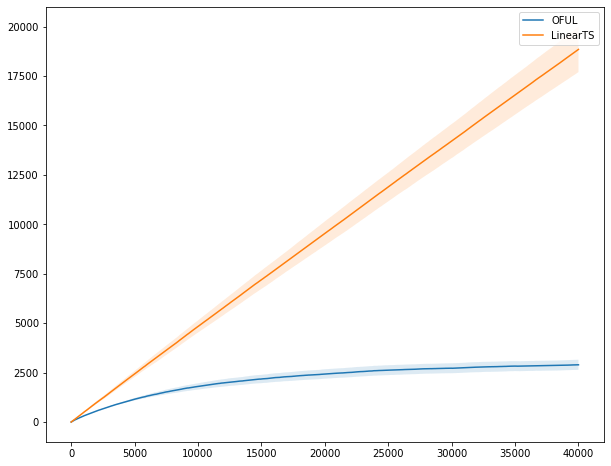

In [23]:
# With the sqrt(d) oversampling

for alg_name in algorithms.keys():
    print(regrets[alg_name])

plt.figure(figsize=(10,8))
for alg_name in regrets.keys():
    data = np.cumsum(regrets[alg_name], axis=1)
    n_rep, T = data.shape
    
    mean_regret = np.mean(data, axis=0)
    std_regret = np.std(data, axis=0) / math.sqrt(n_rep)
    t = np.arange(T)
    plt.plot(t, mean_regret, label=alg_name)
    plt.fill_between(t, mean_regret - 2 * std_regret, mean_regret + 2 * std_regret, alpha=0.15)
plt.legend()
    

[[0.52304365 0.5046263  0.88270088 ... 0.0292869  0.08910811 0.13145651]
 [0.92862863 0.02088293 0.73410453 ... 0.08702536 0.117294   0.13145651]
 [0.40876083 0.42544024 0.43944336 ... 0.0292869  0.08910811 0.13145651]
 [0.02344539 0.3102132  0.22245451 ... 0.0292869  0.08910811 0.13145651]]
[[ 0.857452    0.72491645 -0.04909364 ...  0.22281488  0.34316868
   0.33740783]
 [ 0.66559715  0.67991453  0.24023662 ...  0.20592529  0.2657465
   0.65576678]
 [ 0.12458975  0.10817094  0.1872552  ...  0.07305362  0.13287483
   1.12902338]
 [ 0.93106177  0.07470831 -0.029992   ...  0.06610027  0.16403346
   0.2530761 ]]


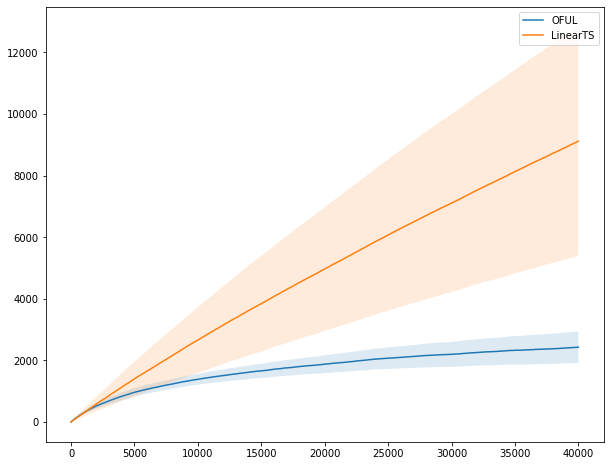

In [26]:
# Without the sqrt(d) oversampling

for alg_name in algorithms.keys():
    print(regrets[alg_name])

plt.figure(figsize=(10,8))
for alg_name in regrets.keys():
    data = np.cumsum(regrets[alg_name], axis=1)
    n_rep, T = data.shape
    
    mean_regret = np.mean(data, axis=0)
    std_regret = np.std(data, axis=0) / math.sqrt(n_rep)
    t = np.arange(T)
    plt.plot(t, mean_regret, label=alg_name)
    plt.fill_between(t, mean_regret - 2 * std_regret, mean_regret + 2 * std_regret, alpha=0.15)
plt.legend()
    

### Using the regret as $R(T) = \sum_t \phi_t^\top (\theta^\star - \theta_t)$

In [19]:
from mvarl_hands_on.utils.coldstart import RandomLinearArms

nb_simulations = 4
T = int(4e4)

algorithms = {
            'OFUL': lambda arm_features, bound_theta: 
              OFUL(arm_features=arm_features, reg_factor=1., delta=0.01,
                 bound_theta=bound_theta, noise_std=config_cs['noise_std']),
             'LinearTS': lambda arm_features, bound_theta:
              LinearTS(arm_features=arm_features, reg_factor=1., delta=0.01,
                 bound_theta=bound_theta, noise_std=config_cs['noise_std'], T=T)
             }

regrets = {}
      
for alg_name in algorithms.keys():
    if alg_name not in regrets.keys():
        regrets[alg_name] = np.zeros((nb_simulations, T))
    
    for k in range(nb_simulations):
        if k % 1 == 0:
            print("{} simulation {}/{}".format(alg_name, k+1, nb_simulations))
        model = ColdStartFromDataset(**config_cs)
#        model = RandomLinearArms()
        alg = algorithms[alg_name](arm_features=model.features, bound_theta=np.linalg.norm(model.theta))

        for t in range(T):
            action = alg.sample_action()
            reward = model.reward(action)
            regrets[alg_name][k, t] =  model.features[action].dot(model.theta  - alg.theta) 
            #regrets[alg_name][k, t] =  model.best_arm_reward() - reward
            
            alg.update(action, reward)
            
        print("Found Theta", alg.theta)
        print("Cum regret on Simulation", np.sum(regrets[alg_name][k, :]), "\n")
    print("\n")


OFUL simulation 1/4
Found Theta [ 0.1305862   0.45157774  0.29821793 -0.61699472 -0.37576281 -0.53055131
  0.44220778  0.35448181 -0.17800372 -0.1467415   0.22574274 -0.19339579
  0.12257143  0.89808631 -0.26494235 -0.18610506  0.7545364   0.28879339
 -0.23279757  0.351849   -0.30481687 -1.17246656 -0.518778   -0.48934101
  0.1917007   0.8386118   0.534645   -0.91770871 -0.41556265 -0.20572599
  0.85861949 -0.48642692  0.49842131  2.44311601 -1.09503052]
Cum regret on Simulation 104.85349721012904 

OFUL simulation 2/4
Found Theta [ 0.1305862   0.45157774  0.29821793 -0.61699472 -0.37576281 -0.53055131
  0.44220778  0.35448181 -0.17800372 -0.1467415   0.22574274 -0.19339579
  0.12257143  0.89808631 -0.26494235 -0.18610506  0.7545364   0.28879339
 -0.23279757  0.351849   -0.30481687 -1.17246656 -0.518778   -0.48934101
  0.1917007   0.8386118   0.534645   -0.91770871 -0.41556265 -0.20572599
  0.85861949 -0.48642692  0.49842131  2.44311601 -1.09503052]
Cum regret on Simulation 104.8534972

[[-2.04311916e+00  9.39978692e-02 -1.12437477e-01 ...  7.65823355e-04
   7.67027541e-04  7.70757225e-04]
 [-3.24421457e-01  6.69435367e-01  6.23759894e-01 ...  9.88408681e-04
  -2.90023796e-04 -5.89247177e-04]
 [-6.20784554e-01  5.18994867e-01  4.21812896e-01 ...  7.13908767e-05
   7.24509717e-05  7.56815444e-05]
 [-1.03107847e+00  8.05251611e-01 -1.02192506e-01 ... -1.46994353e-03
   4.44322291e-04 -1.46359302e-03]]
[[-0.16409536 -0.06662093  0.25398101 ...  0.00212126  0.0012186
   0.00311387]
 [-0.74123959  0.31551079  0.49228547 ...  0.00231246 -0.00415573
   0.00169753]
 [ 0.11581201  0.05261015  0.5000881  ... -0.00384942 -0.00496693
   0.00453207]
 [-0.57309183  0.14088574  0.10571218 ... -0.0015279  -0.00587991
  -0.00239999]]


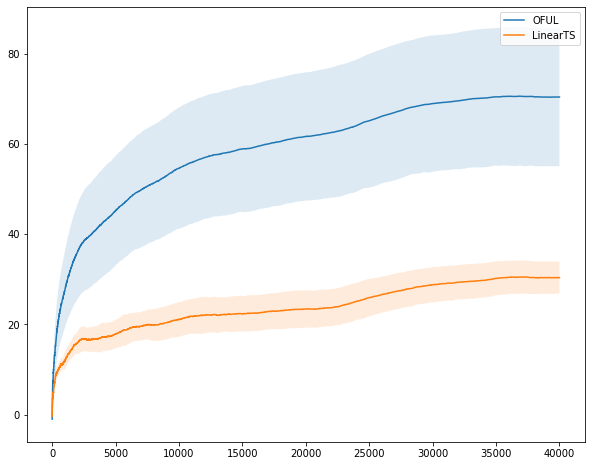

In [17]:
# With the sqrt(d) oversampling

for alg_name in algorithms.keys():
    print(regrets[alg_name])

plt.figure(figsize=(10,8))
for alg_name in regrets.keys():
    data = np.cumsum(regrets[alg_name], axis=1)
    n_rep, T = data.shape
    
    mean_regret = np.mean(data, axis=0)
    std_regret = np.std(data, axis=0) / math.sqrt(n_rep)
    t = np.arange(T)
    plt.plot(t, mean_regret, label=alg_name)
    plt.fill_between(t, mean_regret - 2 * std_regret, mean_regret + 2 * std_regret, alpha=0.15)
plt.legend()
    

[[-1.90943597e-01  6.39651282e-01  5.93941537e-03 ...  5.08678734e-04
   5.11369302e-04  1.64111884e-03]
 [-1.90943597e-01  6.39651282e-01  5.93941537e-03 ...  5.08678734e-04
   5.11369302e-04  1.64111884e-03]
 [ 2.71661430e-01  6.18299759e-01  5.02924444e-01 ... -3.75256494e-04
  -3.74182128e-04 -3.70941188e-04]
 [ 2.71661430e-01  6.18299759e-01  5.02924444e-01 ... -3.75256494e-04
  -3.74182128e-04 -3.70941188e-04]]
[[ 7.38127938e-01  9.08672557e-01 -6.51769106e-02 ... -1.29763369e-03
   4.56714196e-03  7.23842476e-04]
 [ 3.00574207e-01  4.26420714e-01  5.46641341e-01 ...  1.72490996e-03
   4.71793389e-03  1.74766492e-03]
 [-1.97675612e+00  5.11840079e-01  4.55678027e-01 ... -1.00214502e-03
   2.12430798e-02  1.51304434e-03]
 [-7.31670185e-01  1.91185889e-01  3.21575612e-01 ... -9.19306118e-04
   1.90815136e-03 -6.94968546e-04]]


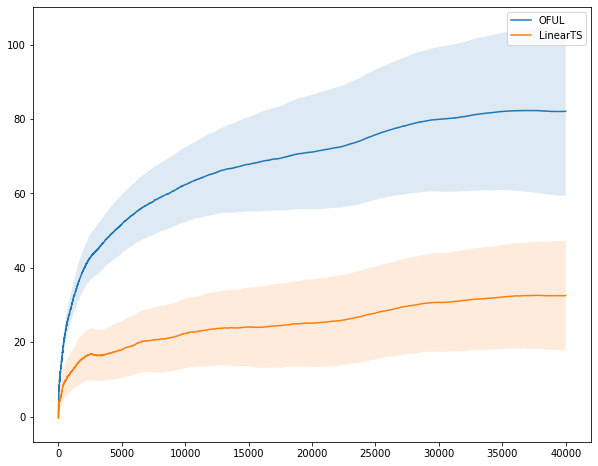

In [20]:
# Without the sqrt(d) oversampling

for alg_name in algorithms.keys():
    print(regrets[alg_name])

plt.figure(figsize=(10,8))
for alg_name in regrets.keys():
    data = np.cumsum(regrets[alg_name], axis=1)
    n_rep, T = data.shape
    
    mean_regret = np.mean(data, axis=0)
    std_regret = np.std(data, axis=0) / math.sqrt(n_rep)
    t = np.arange(T)
    plt.plot(t, mean_regret, label=alg_name)
    plt.fill_between(t, mean_regret - 2 * std_regret, mean_regret + 2 * std_regret, alpha=0.15)
plt.legend()
    